In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys
sys.path.append("..")

from plotting_tools import * 
import geopandas as gpd

In [2]:
person_locs = pd.read_csv("../../../preprocessing/data/1_persons_locs.csv", sep=",", dtype=str)

loc_mapping = pd.read_csv("../../../preprocessing/data/1_mapping_tan_locs.txt", sep=" ", dtype=str, header=None).iloc[:, [0, 1]]
loc_mapping.columns = ["ABM_id", "tan_id"]
loc_mapping_dict = loc_mapping.set_index("ABM_id")["tan_id"].to_dict()

In [3]:
person_locs["Home_ww_area"] = person_locs["Home"].map(loc_mapping_dict)
person_locs["Workplace_ww_area"] = person_locs["Work"].map(loc_mapping_dict)

In [4]:
workplace_sizes = person_locs.groupby("Work")["Id"].count().reset_index().rename(columns={"Id": "count"}).sort_values("count", ascending=False)

In [5]:
worksize_mapping = workplace_sizes.set_index("Work")["count"].to_dict()
person_locs["Workplace_size"] = person_locs["Work"].map(worksize_mapping)

In [6]:
person_locs.head()

,Id,Home,School,Work,Shop,Event,Home_ww_area,Workplace_ww_area,Workplace_size
0,0,0048,-1,0251,0449,0350,181,0,1
1,1,0052,-1,0255,0453,0354,204,0,1
2,2,0056,-1,0259,0457,0358,143,0,1
3,3,0060,-1,0263,0461,0362,153,154,34
4,4,0064,-1,0267,0465,0366,109,0,1


In [7]:
avg_workplace_of_citizens = person_locs[["Home_ww_area"]].drop_duplicates()
avg_workplace_of_citizens["avg_workplace_size"] = np.nan

for area in avg_workplace_of_citizens["Home_ww_area"].unique():
    avg_workplace_size = person_locs.loc[((person_locs["Work"]!="-1")&(person_locs["Home_ww_area"]==area)), "Workplace_size"].mean()
    avg_workplace_of_citizens.loc[avg_workplace_of_citizens["Home_ww_area"] == area, "avg_workplace_size"] = avg_workplace_size


In [8]:
gebiete = gpd.read_file("../MunichModel_shape/Gebiete.shp")
abschnitte = gpd.read_file("../MunichModel_shape/Abschnitte.shp")
knoten = gpd.read_file("../MunichModel_shape/Knoten.shp")

knoten["clear_name"] = ["Schmidbartlangerstr.", 
                  "Schenkendorfstr.", 
                  "Botanischer\nGarten", 
                  "Gräfelfinger\nStr.", #3
                  "Am\nLangwieder\nBach", #4
                  "Neue\nMessstelle 2", 
                  "WWT Gut Großlappen", 
                  "Gyßlinger Becken", #7
                  "Neue\nMessstelle 1", 
                  "WWT Gut Marienhof", #9
                  "Gesamt",
                  "Leopoldstr.", #11
                  "Neue\nMessstelle 4", 
                  "Zulauf\nGut Großlappen", 
                  "Savitstr.",
                  "Wintersteinstr.", ]

knoten["name"] = knoten.clear_name.apply(lambda x: manhole_clear_names[x])

In [9]:
avg_workplace_of_citizens.Home_ww_area = avg_workplace_of_citizens.Home_ww_area.astype(int)

In [10]:
gebiete = pd.merge(gebiete, avg_workplace_of_citizens, left_on="Name", right_on="Home_ww_area", how="left")

In [11]:
%config InlineBackend.print_figure_kwargs = {'dpi': 300, 'bbox_inches': 'tight'}

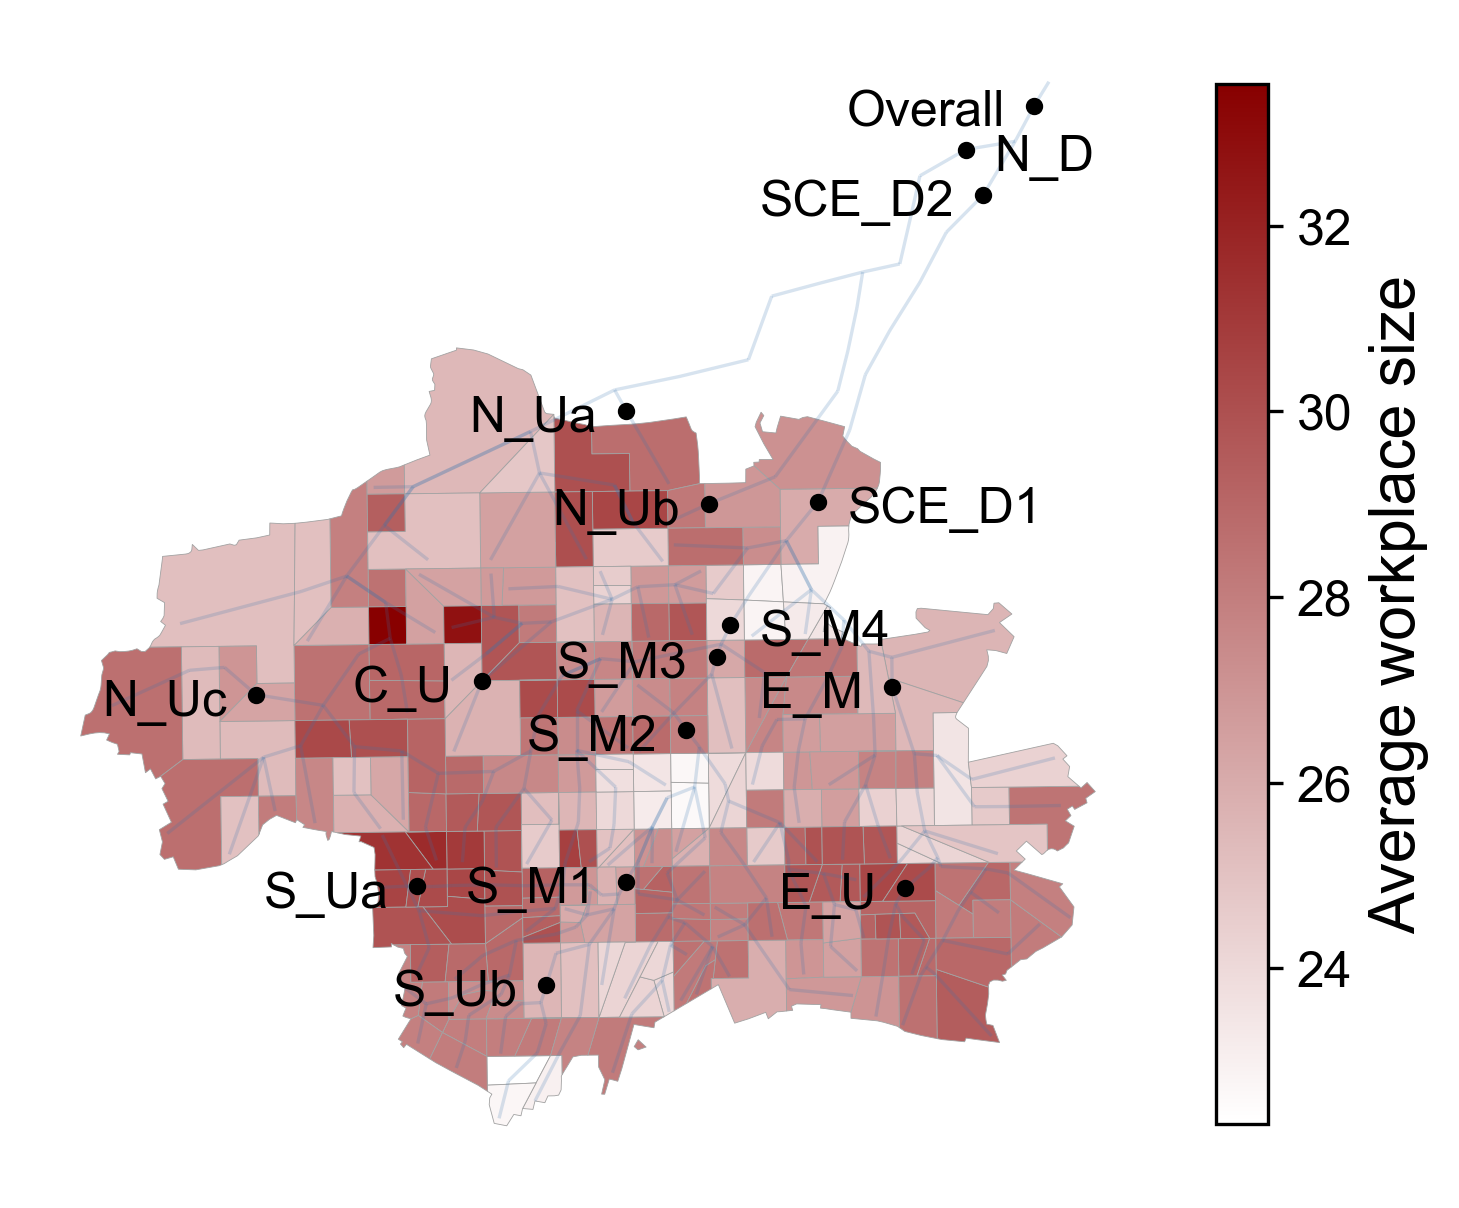

In [14]:
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, red],
)
fig, ax = plt.subplots(figsize=(6,5), dpi=300)

gebiete.plot(
    ax=ax,
    column="avg_workplace_size",
    cmap=cmap, #"viridis_r",
    edgecolor=medium_grey,
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "Average workplace size", "shrink": 0.9}
)
txt_color = black
abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
knoten.plot(ax=ax, color=black, label='Sampling station', zorder=20, markersize=10)

# orientation left of point
for idx, row in knoten.iloc[[0,2,3,4,5,6,7,8,10,11,12,14,15]].iterrows():
    ax.annotate(
        text=row['name'],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(-7, -5),
        textcoords="offset points",
        ha="right",
        color=txt_color,
        fontsize=0.8*15  # Change this value to your desired font size
    )

# orientation right of point
for idx, row in knoten.iloc[[1,9,13]].iterrows():
    ax.annotate(text=row['name'], xy=(row.geometry.x, row.geometry.y),
                xytext=(7, -5), textcoords="offset points", color=txt_color, fontsize=0.8*15)  # Change this value to your desired font size)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()  # Remove plot borders

plt.savefig("../plots/Figure_6/workplace_size_with_stations.png", dpi=300, bbox_inches='tight')
